In [8]:
from google.colab import drive
import os
drive.mount('/content/drive/')
os.chdir('/content/drive/My Drive/Project/')  #import the dataset


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [9]:
!pip install pyprind

In [0]:
import pandas as panda
import numpy as npy
from natsort import natsorted,ns
from string import punctuation
import pyprind
import matplotlib.pyplot as m_plt
from collections import Counter
from keras.preprocessing.text import Tokenizer
from scipy import stats                    #load the libraries

In [0]:
def GET_SCORE(Y_pred,Y_true):
    '''Calculation of the Spearman correlation coefficient'''
    Y_pred = npy.squeeze(Y_pred)
    Y_true = npy.squeeze(Y_true)
    if Y_pred.shape != Y_true.shape:
        print('Input shape doesnt match')
    else:
        if len(Y_pred.shape) == 1:
            Res = panda.DataFrame({'Y_true':Y_true,'Y_pred':Y_pred})
            score_mat = Res[['Y_true','Y_pred']].corr(method='spearman',min_periods=1)
            print('The Spearmans correlation coefficient is: %.3f' % score_mat.iloc[1][0])
        else:
            for ii in range(Y_pred.shape[1]):
                GET_SCORE(Y_pred[:,ii],Y_true[:,ii])           ##spearman score function  1 st is short term and 2ns is for long term memorabilty

In [0]:
def read_captions(fname):
    vn = []
    cap = []
    df = panda.DataFrame();
    with open(fname) as f:
        for line in f:
            pairs = line.split()
            vn.append(pairs[0])
            cap.append(pairs[1])
        df['video']=vn
        df['caption']=cap
    return df                                 #read the captions

In [0]:
def read_c3d(fname):
    with open(fname) as f:
        for line in f:
            C3D =[float(item) for item in line.split()]           #read c3d
    return C3D

In [0]:

def read_hmp(fname):
    """Scan HMP(Histogram of Motion Patterns) features from file"""                        # loading HMP features
    with open(fname) as f:
        for line in f:
            pairs=line.split()
            HMP_temp = { int(p.split(':')[0]) : float(p.split(':')[1]) for p in pairs}
   
    HMP = npy.zeros(6075)
    for idx in HMP_temp.keys():                     # there are 6075 bins, fill zeros with it
        HMP[idx-1] = HMP_temp[idx]            
    return HMP

In [0]:

cap_path = './Dev-set/Captions/dev-set_video-captions.txt'                 # load the captions from dev set
df_cap=read_captions(cap_path)


label_path = './'
labels=panda.read_csv(label_path+'/Dev-set/Ground-truth/ground-truth.csv')             # load the ground truth values from devset

Feat_path = '/content/drive/My Drive/Project/Dev-set/'            # Path for the features dev set

def getnames(featurename):  #getting video names using features' name
  vnames = os.listdir(Feat_path+featurename)
  return vnames

def getpaths(featurename):                                                          #get full path of the features using features' name 
  fpath = [Feat_path+featurename+'/' + x for x in  getnames(featurename)]
  sorted = natsorted(fpath,alg=ns.IGNORECASE)
  print('Feature Path:')
  print(sorted[:5])
  return sorted

In [0]:

def df_C3D():
  path = getpaths('C3D')
  c3d = []
  print('Loading C3D')
  for item in path:               #load C3D and return as an array of list
    c3d.append(read_c3d(item))
  print('done')
  return npy.asarray(c3d)

In [0]:
t
def df_HMP():
  path = getpaths('HMP')
  hmp = []                                   #load hmp and return as an array of lis
  print('Loading HMP')
  for item in path:
    hmp.append(read_hmp(item))
  print('done')
  return npy.asarray(hmp)

In [18]:

import nltk
nltk.download('stopwords')
nltk.download('words')                     #data preprocessing for captions

def rmstopwords(df_cap):
  
  words = set(nltk.corpus.words.words())

  
  stop_words = set(nltk.corpus.stopwords.words('english')) #import stopwords

  cap = df_cap
  newlist, newlist2, newlist3 = ([] for i in range(3))


  for x in cap:
      newlist.append(x.replace('-', ' '))                  #removing delimeters

  for i in newlist:
    sent = i
    newlist2.append(" ".join(w for w in nltk.wordpunct_tokenize(sent) if not w.lower() in stop_words or not w.isalpha()))          #removing stopwords
  print(newlist2)
  return newlist2

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [19]:

df_cap['caption']=rmstopwords(df_cap['caption']) #removestopwords data preprcoessing

['blonde woman massaged tilt', 'roulette table spinning ball closeup shot', 'khr gangsters', 'medical helicopter hovers airport', 'couple relaxing picnic crane shot', 'passing older man reading', 'christmas village national christmas tree', 'unhappy friends looking something interesting television', 'hoover dam tourists traffic', 'happy girl stretching relaxing station', 'bread conveyor', 'close racks computer equipment flashing lights', 'modern family overdue burn wife', 'woman tweeting phone street restaurant', 'videoblocks woman model released points sign another woman comes', 'bird barren twig ruins background', 'two walking businessman', 'timelapse snow mountains', 'african hartebeest coming water', 'potter works crockery creation process pottery potters wheel', 'couple relaxing new flat', 'happy couple relaxing tree shadow', 'grandmother walks grandson baby stroller yard camera motion wide shot', 'business report meeting', 'female friends drinking coffee chatting sofa', 'petco pa

In [0]:

def countwords(df):
  counts = Counter()           #counting and tokenizing captions i.e data preprocessing for text features

  pbar = pyprind.ProgBar(len(df['caption']), title='Counting word occurrences')   # setup progress tracker
  for i, cap in enumerate(df['caption']):
    
      text = ''.join([c if c not in punctuation else ' ' for c in cap]).lower()    # convert words to lower case 
      df.loc[i,'caption'] = text
      pbar.update()
      counts.update(text.split())
  print('')
  return counts

def tokenize(counts,df):
  
  len_token = len(counts)  # build the word index
  tokenizer = Tokenizer(num_words=len_token)
  tokenizer.fit_on_texts(list(df.caption.values))
  one_hot_res = tokenizer.texts_to_matrix(list(df.caption.values),mode='binary')
  return one_hot_res

In [21]:
counts=countwords(df_cap)
print(counts)
print(len(counts))

Counting word occurrences
0% [##############################] 100% | ETA: 00:00:00


Counter({'woman': 899, 'young': 724, 'man': 559, 'slow': 495, 'motion': 452, 'couple': 318, 'sitting': 304, 'girl': 291, 'happy': 279, 'beach': 270, 'park': 256, 'walking': 237, 'close': 230, 'camera': 230, 'using': 218, 'shot': 215, 'smiling': 198, 'looking': 195, 'two': 191, 'people': 188, 'tablet': 184, 'water': 171, 'female': 150, 'computer': 149, 'view': 149, 'laptop': 139, 'playing': 137, 'sunset': 137, 'beautiful': 133, 'videoblocks': 131, 'running': 130, 'talking': 129, 'city': 128, 'working': 127, 'eating': 126, 'little': 126, 'family': 125, 'mother': 124, 'background': 122, 'home': 122, 'standing': 121, 'phone': 115, 'sea': 113, 'national': 112, 'african': 111, 'attractive': 111, 'tree': 107, 'snow': 103, 'drinking': 102, 'hands': 102, 'steadicamof': 102, 'modern': 101, 'street': 99, 'business': 98, 'road': 98, 'american': 97, 'field': 97, 'boy': 96, 'white': 95, 'new': 93, 'businessman': 92, 'portrait': 92, 'son': 91, 'table': 90, 'swimming': 90, 'group': 86, 'closeup': 85,


Total time elapsed: 00:00:01


In [22]:
captions = tokenize(counts,df_cap)
print(len(captions))                 #checking of captions

6000


In [23]:

print(labels.head()) #Checking the format of ground_truth

          video  ...  nb_long-term_annotations
0   video3.webm  ...                        13
1   video4.webm  ...                        12
2   video6.webm  ...                        10
3   video8.webm  ...                        11
4  video10.webm  ...                        10

[5 rows x 5 columns]


In [24]:
f1 = df_C3D()       #loading C3d

Feature Path:
['/content/drive/My Drive/Project/Dev-set/C3D/video3.txt', '/content/drive/My Drive/Project/Dev-set/C3D/video4.txt', '/content/drive/My Drive/Project/Dev-set/C3D/video6.txt', '/content/drive/My Drive/Project/Dev-set/C3D/video8.txt', '/content/drive/My Drive/Project/Dev-set/C3D/video10.txt']
Loading C3D
done


In [28]:

f2 = df_HMP()      #loading HMP

Feature Path:
['/content/drive/My Drive/Project/Dev-set/HMP/video3.txt', '/content/drive/My Drive/Project/Dev-set/HMP/video4.txt', '/content/drive/My Drive/Project/Dev-set/HMP/video6.txt', '/content/drive/My Drive/Project/Dev-set/HMP/video8.txt', '/content/drive/My Drive/Project/Dev-set/HMP/video10.txt']
Loading HMP
done


In [30]:
print(len(f1),len(f2))       #checking C3d and HMP length 

6000 6000


In [0]:
from sklearn.ensemble import RandomForestRegressor


In [0]:

Y_rf = labels[['short-term_memorability','long-term_memorability']].values
                                                                                #Short term and long term memorability score  for random forest



X_rf = npy.concatenate((f1,f2,captions), axis=1)

In [0]:

from keras import Sequential, layers, regularizers, optimizers
from sklearn.model_selection import train_test_split

In [78]:
X_train, X_test, Y_train, Y_test = train_test_split(X_rf,Y_rf, test_size=0.20, random_state=42)

#setting parameters
rf = RandomForestRegressor(n_estimators=20,max_depth=10,random_state=50,verbose=2)

#training dataset
rf.fit(X_train,Y_train)

print(rf.decision_path(X_train))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 20


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.9s remaining:    0.0s


building tree 2 of 20
building tree 3 of 20
building tree 4 of 20
building tree 5 of 20
building tree 6 of 20
building tree 7 of 20
building tree 8 of 20
building tree 9 of 20
building tree 10 of 20
building tree 11 of 20
building tree 12 of 20
building tree 13 of 20
building tree 14 of 20
building tree 15 of 20
building tree 16 of 20
building tree 17 of 20
building tree 18 of 20
building tree 19 of 20
building tree 20 of 20
(<4800x11352 sparse matrix of type '<class 'numpy.longlong'>'
	with 1048040 stored elements in Compressed Sparse Row format>, array([    0,   511,   944,  1511,  2168,  2737,  3186,  3599,  4076,
        4617,  5460,  6091,  6634,  7457,  7906,  8661,  9094,  9627,
       10240, 10985, 11352]))


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  3.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


In [79]:
rfpredictions = rf.predict(X_test)
print(rfpredictions.shape)

(1200, 2)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


In [80]:
GET_SCORE(rfpredictions,Y_test) #Score of random forest

The Spearmans correlation coefficient is: 0.300
The Spearmans correlation coefficient is: 0.141


In [0]:
model.save('./my_model.h5') # save random forest model

In [0]:

#Short term and long term memorability score 
Y_nn = labels[['short-term_memorability','long-term_memorability']].values

X_nn = npy.concatenate((f1,f2,captions), axis=1)

In [0]:

X_train, X_test, Y_train, Y_test = train_test_split(X_nn,Y_nn, test_size=0.20, random_state=40) #Splitting dataset into test and train

Train on 4800 samples, validate on 1200 samples
Epoch 1/20
4800/4800 [==============================] - 2s 383us/step - loss: 0.2055 - acc: 0.5167 - val_loss: 0.0333 - val_acc: 0.6958
Epoch 2/20
4800/4800 [==============================] - 1s 265us/step - loss: 0.1057 - acc: 0.5606 - val_loss: 0.0307 - val_acc: 0.7242
Epoch 3/20
4800/4800 [==============================] - 1s 273us/step - loss: 0.0772 - acc: 0.5704 - val_loss: 0.0251 - val_acc: 0.7242
Epoch 4/20
4800/4800 [==============================] - 1s 269us/step - loss: 0.0586 - acc: 0.6021 - val_loss: 0.0170 - val_acc: 0.7242
Epoch 5/20
4800/4800 [==============================] - 1s 258us/step - loss: 0.0479 - acc: 0.6231 - val_loss: 0.0172 - val_acc: 0.7242
Epoch 6/20
4800/4800 [==============================] - 1s 271us/step - loss: 0.0379 - acc: 0.6535 - val_loss: 0.0145 - val_acc: 0.7242
Epoch 7/20
4800/4800 [==============================] - 1s 267us/step - loss: 0.0320 - acc: 0.6783 - val_loss: 0.0143 - val_acc: 0.7242


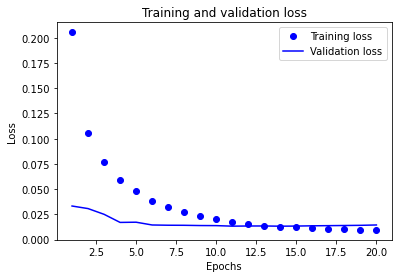

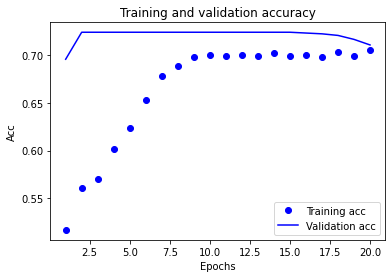

In [40]:


model = Sequential()
model.add(layers.Dense(20,activation='selu',kernel_regularizer=regularizers.l2(0.00001)))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(25,activation='selu',kernel_regularizer=regularizers.l2(0.00001)))
model.add(layers.Dropout(0.7))
model.add(layers.Dense(2,activation='selu'))

 
model.compile(optimizer='adam',loss='mse',metrics=['acc']) # compile the mode
 
history = model.fit(X_train,Y_train,epochs=20,validation_data=(X_test,Y_test)) # training the model 



loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(loss)+1)

m_plt.plot(epochs,loss,'bo',label='Training loss')
m_plt.plot(epochs,val_loss,'b',label='Validation loss')
m_plt.title('Training and validation loss')
m_plt.xlabel('Epochs')
m_plt.ylabel('Loss')                             # visualizing the Neural Network model
m_plt.legend()
m_plt.show()

m_plt.figure()
acc = history.history['acc']
val_acc = history.history['val_acc']
m_plt.plot(epochs, acc, 'bo', label='Training acc')
m_plt.plot(epochs, val_acc, 'b', label='Validation acc')
m_plt.title('Training and validation accuracy')
m_plt.xlabel('Epochs')
m_plt.ylabel('Acc')
m_plt.legend()
m_plt.show()

In [41]:
print(len(X_nn),Y_nn.shape)

6000 (6000, 2)


In [42]:

nnpredictions = model.predict(X_test)
print(nnpredictions.shape)              

(1200, 2)


In [43]:

GET_SCORE(nnpredictions, Y_test) #neural Network Score

The Spearmans correlation coefficient is: 0.319
The Spearmans correlation coefficient is: 0.187


In [0]:

model.save('./my_model.h5')

In [0]:
predictions_test = npy.add(nnpredictions ,rfpredictions)

In [54]:
print(predictions_test) ##ensemble weighted Average PRedctions using prpevious models

[[1.71221171 1.55238167]
 [1.72451005 1.5624468 ]
 [1.77324192 1.69311722]
 ...
 [1.71336422 1.56760888]
 [1.65678407 1.40555714]
 [1.72346518 1.52295404]]


In [55]:
predictions_test.shape

(1200, 2)

In [59]:
predictions_test = npy.divide(predictions_test, 2)
print(predictions_test)       #ensemble weightedaverage Predictions

[[0.42805293 0.38809542]
 [0.43112751 0.3906117 ]
 [0.44331048 0.42327931]
 ...
 [0.42834106 0.39190222]
 [0.41419602 0.35138929]
 [0.4308663  0.38073851]]


In [60]:
GET_SCORE(predictions_test, Y_test,)     #ensemble weighted Average Score

The Spearmans correlation coefficient is: 0.260
The Spearmans correlation coefficient is: 0.175


TEST SET Predcitions

In [0]:
# load the test set version of captions
cap_path = './Test-set/Captions_test/test-set-1_video-captions.txt'
df_cap_test=read_captions(cap_path)

label_path = './'
labels_test=panda.read_csv(label_path+'/Test-set/Ground-truth_test/ground_truth_template.csv')

#Overwriting the Feat_Path to test dataset location
Feat_path = '/content/drive/My Drive/Project/Test-set/'

In [0]:
def getnames(featurename):
  vnames = os.listdir(Feat_path+featurename+'_test')
  return vnames

def getpaths(featurename):
  fpath = [Feat_path+featurename+'_test/' + x for x in  getnames(featurename)]
  sorted = natsorted(fpath,alg=ns.IGNORECASE)
  print('Feature Path:')
  print(sorted[:5])
  return sorted

In [63]:
df_cap_test['caption']= rmstopwords(df_cap_test['caption'])

df_cb = df_cap.append(df_cap_test,ignore_index = True)
counts_test = countwords(df_cb)

print(counts_test)
print(len(counts_test))

# build the word index 
captions_test = tokenize(counts_test,df_cb)

Counting word occurrences


['green jeep struggling drive huge rocks', 'hiking woman tourist walking forward mountains sunset shining sun woman looking back calling unseen friends catch slow motion', 'close african american doctors hands using sphygmomanometer measure blood pressure', 'slow motion man using treadmill gym regular physical activity necessary people ages', 'slow motion photographer national park', 'group mixed race american patriotic peoples american flag hands placed back looking straight', 'business people train draw diagrams board learning tablet', 'father daughters smiling', 'mechanic using rotary polisher paintwork black car body shop finish repair accident', 'young couple conversation hotel corridor', 'jerusalem street market timelapse', 'williamsburg capitol pan right', 'hiker lone tree red rock canyon', 'reenactment event kettle corn', 'friends eat cake cafe', 'st petersburg russia april young man excited try vr attraction sitting special swinging chair getting vr headset headphones tech tre

0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01



Counter({'woman': 1202, 'young': 957, 'man': 725, 'slow': 628, 'motion': 568, 'couple': 424, 'girl': 399, 'sitting': 399, 'happy': 364, 'park': 341, 'beach': 340, 'walking': 313, 'close': 312, 'camera': 300, 'shot': 292, 'using': 283, 'smiling': 263, 'looking': 261, 'two': 244, 'people': 244, 'tablet': 242, 'water': 224, 'view': 203, 'computer': 196, 'female': 195, 'talking': 186, 'sunset': 186, 'videoblocks': 184, 'working': 180, 'beautiful': 179, 'laptop': 176, 'playing': 175, 'city': 175, 'running': 172, 'little': 168, 'eating': 167, 'family': 164, 'background': 156, 'mother': 154, 'phone': 151, 'tree': 148, 'home': 147, 'national': 142, 'standing': 142, 'hands': 140, 'sea': 140, 'african': 138, 'drinking': 135, 'snow': 134, 'business': 133, 'steadicamof': 131, 'field': 131, 'modern': 130, 'street': 129, 'attractive': 129, 'american': 125, 'boy': 123, 'businessman': 121, 'swimming': 121, 'son': 120, 'white': 120, 'portrait': 119, 'road': 119, 'new': 117, 'closeup': 114, 'green': 11

In [64]:
print(len(captions_test))

8000


In [65]:

f3_test = df_C3D()

Feature Path:
['/content/drive/My Drive/Project/Test-set/C3D_test/video7494.txt', '/content/drive/My Drive/Project/Test-set/C3D_test/video7495.txt', '/content/drive/My Drive/Project/Test-set/C3D_test/video7496.txt', '/content/drive/My Drive/Project/Test-set/C3D_test/video7497.txt', '/content/drive/My Drive/Project/Test-set/C3D_test/video7498.txt']
Loading C3D
done


In [67]:
f4_test = df_HMP()

Feature Path:
['/content/drive/My Drive/Project/Test-set/HMP_test/video7494.txt', '/content/drive/My Drive/Project/Test-set/HMP_test/video7495.txt', '/content/drive/My Drive/Project/Test-set/HMP_test/video7496.txt', '/content/drive/My Drive/Project/Test-set/HMP_test/video7497.txt', '/content/drive/My Drive/Project/Test-set/HMP_test/video7498.txt']
Loading HMP
done


In [68]:
print(len(f3_test),len(f4_test))

2000 2000


In [0]:
X_train = npy.concatenate((f2,captions_test[:6000]), axis=1)
X_test =  npy.concatenate((f4_test,captions_test[6000:8000]), axis=1)
Y_train = labels[['short-term_memorability','long-term_memorability']].values      # conconatnated features into one for test set
Y_test = []

In [70]:
model_test = Sequential()
model_test.add(layers.Dense(30,activation='selu',kernel_regularizer=regularizers.l2(0.00001)))
model_test.add(layers.Dropout(0.3))
model_test.add(layers.Dense(25,activation='selu',kernel_regularizer=regularizers.l2(0.00001)))
model_test.add(layers.Dropout(0.7))
model_test.add(layers.Dense(2,activation='selu'))



# compile the model 
model_test.compile(optimizer='adam',loss='mse',metrics=['accuracy'])

# training the model 

history = model_test.fit(X_train,Y_train,epochs=20)

Epoch 1/20
6000/6000 [==============================] - 2s 325us/step - loss: 0.2111 - accuracy: 0.5117
Epoch 2/20
6000/6000 [==============================] - 2s 291us/step - loss: 0.1089 - accuracy: 0.5380
Epoch 3/20
6000/6000 [==============================] - 2s 284us/step - loss: 0.0759 - accuracy: 0.5623
Epoch 4/20
6000/6000 [==============================] - 2s 291us/step - loss: 0.0551 - accuracy: 0.5955
Epoch 5/20
6000/6000 [==============================] - 2s 282us/step - loss: 0.0422 - accuracy: 0.6402
Epoch 6/20
6000/6000 [==============================] - 2s 284us/step - loss: 0.0325 - accuracy: 0.6687
Epoch 7/20
6000/6000 [==============================] - 2s 294us/step - loss: 0.0263 - accuracy: 0.6862
Epoch 8/20
6000/6000 [==============================] - 2s 294us/step - loss: 0.0219 - accuracy: 0.6903
Epoch 9/20
6000/6000 [==============================] - 2s 293us/step - loss: 0.0180 - accuracy: 0.6983
Epoch 10/20
6000/6000 [==============================] - 2s 306u

In [71]:
predictionnn_test = model_test.predict(X_test)
print(predictionnn_test)                        #test Set Predictions on neural Set

[[0.85105133 0.7683709 ]
 [0.7918561  0.75290555]
 [0.8995825  0.83575606]
 ...
 [0.8783476  0.7972223 ]
 [0.91141295 0.8647998 ]
 [0.883858   0.7973548 ]]


In [0]:
Features = panda.DataFrame({'video': natsorted(labels_test['video']),
                    'short-term_memorability': [row[0] for row in predictionnn_test],
                    'long-term_memorability':[row[1] for row in predictionnn_test]
                        })


In [74]:

print(Features.head())
Features.to_csv('./test_predictions2.csv')

   video  short-term_memorability  long-term_memorability
0   7494                 0.851051                0.768371
1   7495                 0.791856                0.752906
2   7496                 0.899583                0.835756
3   7497                 0.867676                0.752624
4   7498                 0.831411                0.735739


In [0]:
label_path = './'
st_label=panda.read_csv(label_path+'/test_predictions2.csv')
lt_label=panda.read_csv(label_path+'/test_predictions2.csv')     #reading the test Predictions from CSV Files

In [76]:

#Getting the CSV File After Merging 
Final = panda.DataFrame({'video': st_label['video'],
                    'short-term_memorability': st_label['short-term_memorability'],
                    'long-term_memorability':lt_label['long-term_memorability']
                        })

print(Final.head())
Final.to_csv('./ground_truth.csv')                         

   video  short-term_memorability  long-term_memorability
0   7494                 0.851051                0.768371
1   7495                 0.791856                0.752906
2   7496                 0.899583                0.835756
3   7497                 0.867676                0.752624
4   7498                 0.831411                0.735739
